In [1]:
import mrcfile

import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the two half maps from: https://www.ebi.ac.uk/emdb/EMD-24822

map_1_file = ''
map_2_file = ''

with mrcfile.open(map_1_file) as mrc:
    y1 = mrc.data
    voxel = mrc.voxel_size.x
    mrc.close()
    
with mrcfile.open(map_2_file) as mrc:
    y2 = mrc.data
    mrc.close()    

In [4]:
shape = y1.shape
N = shape[0]
r = N // 2
r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in shape]))/2))

r_signal = 115  # input radius of the structure to be masked for noise estimate

rdists = fsc.radial_distance_grid(y1.shape)  

sphere_mask = fsc.sphere_mask(rdists, r_signal)

eps = y1 * ~sphere_mask  # estimate the noise from the excluded region

ratio = np.sum(~sphere_mask) / y1.size

freq = fsc.get_radial_spatial_frequencies(y1, voxel)

In [5]:
### compute the spherically averaged power spectrum ###

y1_raps = fsc.compute_spherically_averaged_power_spectrum(y1, r)
eps_raps = fsc.compute_spherically_averaged_power_spectrum(eps, r)

In [6]:
### compute the FSC and SFSC ###

fsc_y1y2 = fsc.two_volume_fsc(y1, y2, rmax=r)

y_whitened = fsc.whitening_transform(y1, eps, r_corner, ratio) 
y_upsample = fsc.fourier_upsample(y_whitened, 2)

sfsc_upsample = np.mean(fsc.single_volume_fsc(y_upsample, rmax=r, n_splits=1, whiten_upsample=True), axis=0)

# # or the following approximately equal alternative
# ssnr_estimate = (y1_raps - eps_raps/ratio) / (eps_raps/ratio)
# fsc_from_ssnr = ssnr_estimate / (1 + ssnr_estimate)

print(' fsc: ', fsc.linear_interp_resolution(fsc_y1y2, freq))
print('sfsc: ', fsc.linear_interp_resolution(sfsc_upsample[1:], freq[1:]))

 fsc:  4.45
sfsc:  4.45


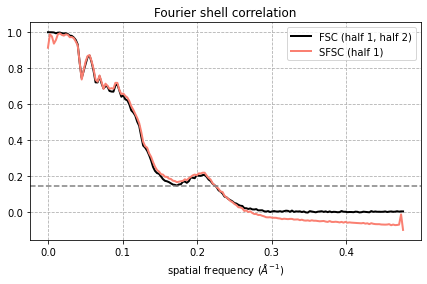

In [7]:
plt.figure(figsize=(7,4))
plt.plot(freq, fsc_y1y2, color='k', linewidth=2, label='FSC (half 1, half 2)')
plt.plot(freq, sfsc_upsample, color='salmon', linewidth=2, label='SFSC (half 1)')
plt.axhline(1/7, color='gray', linestyle='--')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
plt.legend()
# plt.savefig('')
plt.show()

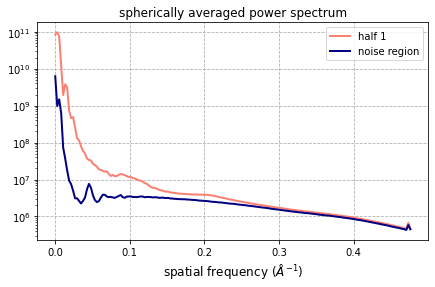

In [8]:
plt.figure(figsize=(7,4))
plt.semilogy(freq, y1_raps, color='salmon', linewidth=2, label='half 1')
plt.semilogy(freq, eps_raps, color='navy', linewidth=2, label='noise region')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')
plt.legend()
# plt.savefig('')
plt.show()

In [9]:
# used to set the vmin, vmax to be on same scale for image pairs
print(np.amin(y1[...,N//2]), np.amax(y1[...,N//2]))
print(np.amin(fsc.log_abs(fsc.ft2(y1[...,N//2]))), np.amax(fsc.log_abs(fsc.ft2(y1[...,N//2]))))

-0.58214146 1.9688926
2.9781334095964613e-05 8.415690090566216


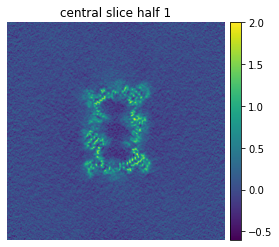

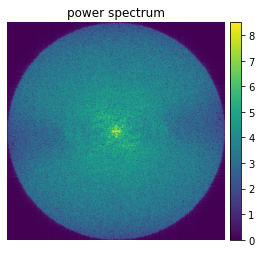

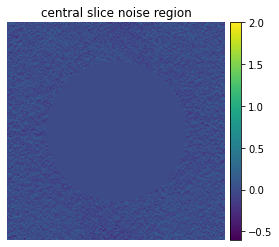

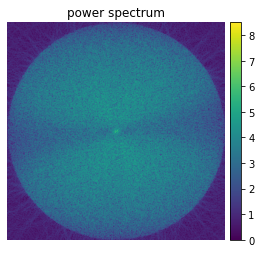

In [10]:
plt.figure(figsize=(5,4))
plt.imshow(y1[...,N//2], vmin=-0.6, vmax=2)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('central slice half 1')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1[...,N//2])), vmin=0, vmax=8.5)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('power spectrum')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(eps[...,N//2], vmin=-0.6, vmax=2)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('central slice noise region')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(eps[...,N//2])), vmin=0, vmax=8.5)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('power spectrum')
# plt.savefig('')
plt.show()